In [1]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose
import dm_control

import cv2


In [2]:
# Initialize simulation
run_time = 0.8
sim_params = MuJoCoParameters(timestep=1e-4, render_mode="saved", render_playspeed=0.1, render_camera="Animat/camera_RFTarsus1_zoomin",
                              enable_adhesion = True,
                                draw_contacts=True,
                                decompose_contacts=False,
                                draw_gravity=False,
                                align_camera_with_gravity=False,
                                )

nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
)

In [3]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
print('Dict keys:', data.keys())
print('Length of time series:', len(data['joint_RFCoxa']))
print('Metadata:', data['meta'])

Dict keys: dict_keys(['meta', 'joint_LFCoxa_yaw', 'joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_LMCoxa_yaw', 'joint_LMCoxa', 'joint_LMCoxa_roll', 'joint_LMFemur', 'joint_LMFemur_roll', 'joint_LMTibia', 'joint_LMTarsus1', 'joint_LHCoxa_yaw', 'joint_LHCoxa', 'joint_LHCoxa_roll', 'joint_LHFemur', 'joint_LHFemur_roll', 'joint_LHTibia', 'joint_LHTarsus1', 'joint_RFCoxa_yaw', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_RMCoxa_yaw', 'joint_RMCoxa', 'joint_RMCoxa_roll', 'joint_RMFemur', 'joint_RMFemur_roll', 'joint_RMTibia', 'joint_RMTarsus1', 'joint_RHCoxa_yaw', 'joint_RHCoxa', 'joint_RHCoxa_roll', 'joint_RHFemur', 'joint_RHFemur_roll', 'joint_RHTibia', 'joint_RHTarsus1'])
Length of time series: 2000
Metadata: {'timestep': 0.0005, 'source_file': '/home/sibwang/Downloads/joint_angles__210902_PR_Fly1.pkl', 'time_range': (3.0, 4.0)}


In [5]:
# Interpolate 5x
num_steps = int(run_time / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), num_steps))
measure_t = np.arange(len(data['joint_LFCoxa'])) * data['meta']['timestep']
interp_t = np.arange(num_steps) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

# Run the example and get timestamp of the rendered frames

In [6]:
# Run simulation
obs, info = nmf.reset()

obs_list = [obs]

frame_timestep_list = []
frame_timestamp = []

for i in trange(num_steps):

    joint_pos = data_block[:, i]
    adhesion = nmf.get_adhesion_vector()  
    action = {'joints': joint_pos, "adhesion": adhesion}
    obs, reward, terminated, truncated, info = nmf.step(action)
    render_status = nmf.render()
    if render_status:
        frame_timestamp.append(nmf.curr_time)
        frame_timestep_list.append(i)

    obs_list.append(obs)

100%|██████████| 8000/8000 [00:31<00:00, 250.03it/s]


In [7]:
video_path = Path('leg_viewpoint/video.mp4')
nmf.save_video(video_path, stabilization_time = 0)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

# Run until clostest to selected timestamp

In [43]:
selected_timestamp = 0.023 * 10
closest_id = np.argmin(np.abs(np.array(frame_timestamp) - selected_timestamp))

closest_num_steps = frame_timestep_list[closest_id]

obs_list = []

nmf.reset()

for i in trange(closest_num_steps):

    joint_pos = data_block[:, i]
    adhesion = nmf.get_adhesion_vector()  
    action = {'joints': joint_pos, "adhesion": adhesion}
    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list.append(obs)

100%|██████████| 2295/2295 [00:04<00:00, 521.97it/s]


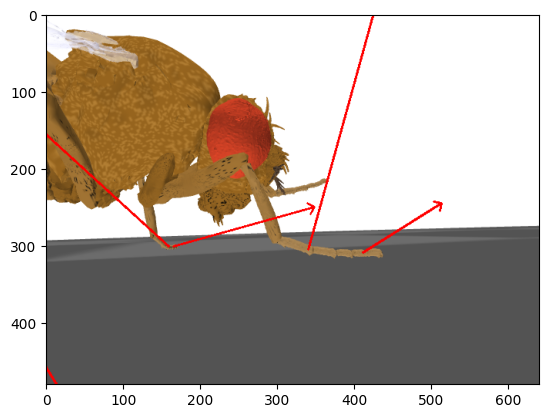

In [44]:
nmf._last_render_time = 0
nmf.render()
img = nmf.get_last_frame()

plt.imshow(img)

# Get closeview and forces foreleg adhesion

In [45]:
width, height = sim_params.render_window_size
img = nmf.physics.render(width=width, height=height, camera_id=nmf.sim_params.render_camera)
dm_camera = dm_control.mujoco.Camera(
                nmf.physics,
                camera_id=nmf.sim_params.render_camera,
                width=width,
                height=height,
            )

scaling_factor_contact = 0.2
scaling_factor_adh = 0.03

camera_matrix = dm_camera.matrix
arrow_start_adh = nmf.physics.named.data.geom_xpos['Animat/RFTarsus5_collision'].copy()
arrow_end_adh = arrow_start_adh + np.array([0.0, 0.0, -1.0])*nmf.sim_params.adhesion_gain*scaling_factor_adh

arrow_starts_contact = []
arrow_ends_contact = []
for i in range(1, 6):
    index_RFTarsus_contact = nmf.contact_sensor_placements.index(f"Animat/RFTarsus{i}")
    arrow_starts_contact.append(nmf.physics.named.data.geom_xpos[f"Animat/RFTarsus{i}_collision"].copy())
    #arrow_ends_contact.append(arrow_starts_contact[-1] + obs['contact_forces'][:, index_RFTarsus_contact]*scaling_factor_contact)
    arrow_ends_contact.append(arrow_starts_contact[-1] + nmf._last_contact_force[:, index_RFTarsus_contact]*scaling_factor_contact)

arrows_contacts = np.hstack([arrow_starts_contact, arrow_ends_contact]).reshape((-1, 3))

xyz_global = np.vstack([arrow_start_adh, arrow_end_adh,
                        arrows_contacts]).T

# Camera matrices multiply homogenous [x, y, z, 1] vectors.
corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
corners_homogeneous[:3, :] = xyz_global

# Project world coordinates into pixel space. See:
# https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
xs, ys, s = camera_matrix @ corners_homogeneous

# x and y are in the pixel coordinate system.
x = np.rint(xs / s).astype(int)
y = np.rint(ys / s).astype(int)

In [46]:
# save raw image
cv2.imwrite('raw_panel.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

True

True

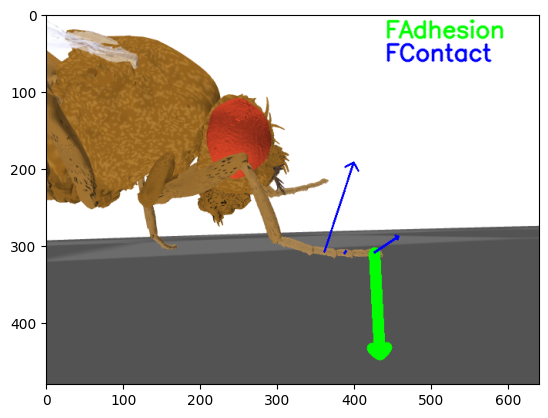

In [47]:
rgb_contact= (0, 0, 255)
rgb_adhesion = (0, 255, 0)

a_width = 2

img = img.astype(np.uint8)
for i in range(0, len(x), 2):
    pts1 = x[i], y[i]
    pts2 = x[i+1], y[i+1]
    rgb = rgb_contact
    a_width = 2
    if i == 0:
        rgb = rgb_adhesion
        a_width = int(2*scaling_factor_contact/scaling_factor_adh)
    if not np.any(pts1 == pts2):
        img = cv2.arrowedLine(img, pts1, pts2, rgb, a_width)
        
# add text
font = cv2.FONT_HERSHEY_SIMPLEX
img = cv2.putText(img, 'FAdhesion', (width-200, 30), font, 1, rgb_adhesion, 2, cv2.LINE_AA)
img = cv2.putText(img, 'FContact', (width-200, 60), font, 1, rgb_contact, 2, cv2.LINE_AA)

plt.imshow(img)
cv2.imwrite('arrow_panel.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))